In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

from amdt import Solver
from tqdm import tqdm

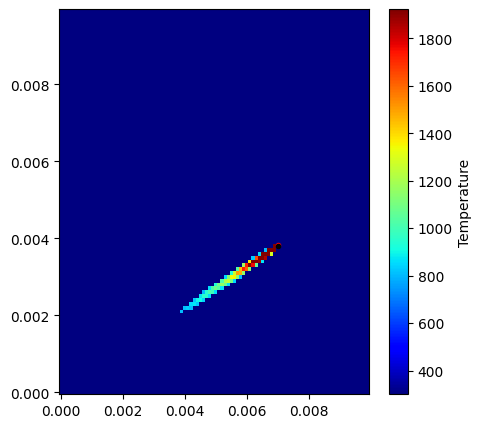

In [2]:
mesh = {
    "b_c": "temp",
    # "x_location": 0, 
    # "y_location": 0,
    # "x_min": 0.06,
    # "x_max": 0.12,
    # "y_min": 0.08,
    # "y_max": 0.12,
    # "z_min": -800e-6,
    # "z_max": 0,
    # "x_start_pad": 200e-6, 
    # "y_start_pad": 200e-6,
    # "x_end_pad": 200e-6, 
    # "y_end_pad": 200e-6,
}

solver = Solver()
# solver.forward({"dt": 0.01, "phi": 0.5, "power": 100}, model="eagar-tsai")
solver.forward({"dt": 0.01, "phi": 0.5, "power": 100}, model="rosenthal")
# solver.forward({"dt": 0.1, "phi": 0.0, "power": 100}, model="eagar-tsai")
# solver.forward({"dt": 0.1, "phi": 0.0, "power": 100}, model="rosenthal")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
c = ax.pcolormesh(solver.xs, solver.ys, solver.theta[:, :, -1].T, cmap = 'jet', vmin = 300, vmax = 1923)
ax.plot(solver.location[0], solver.location[1] ,'r.')
ax.plot(solver.xs[solver.location_idx[0]], solver.ys[solver.location_idx[1]], 'k.')

fig.colorbar(c, ax=ax, label="Temperature")
plt.show()

/tmp/ipykernel_579818/1551841709.py:30: RuntimeWarning: invalid value encountered in sqrt
  r_values.append(np.sqrt(R**2 - z**2))
/tmp/ipykernel_579818/1551841709.py:31: RuntimeWarning: invalid value encountered in sqrt
  r_values_negative.append(-np.sqrt(R**2 - z**2))


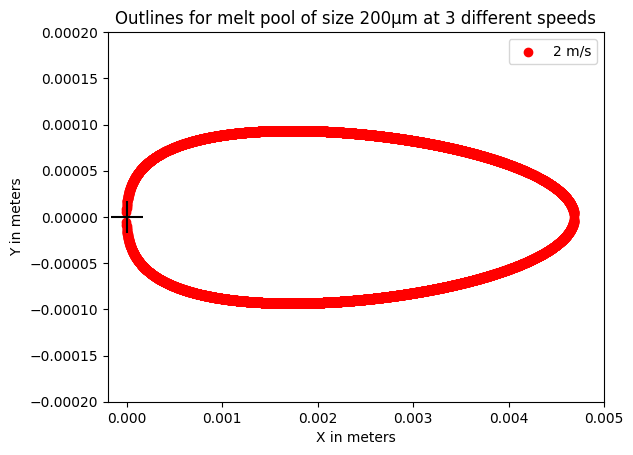

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Inconel 625 alloy properties
epsilon = 0.60            # absorptivity
k = 10                    # thermal_conductivity
rho = 8400                # density
c_p = 470                 # heat_capacity
alpha = k / (rho * c_p)   # thermal_diffusivity
t_delta = 1299.85         # temperature melting - temperature initial

def rosenthal(R, v, p):
    return R + (((2*alpha)/v) * np.log((2 * np.pi * k * R * t_delta)/(epsilon * p)))

color_values = ["r", "g", "b"]
v_values = [2]                  # velocities
p_values = [638.341]  # powers

plt.axis([-200 * 10 ** -6, 0.005, -200 * 10 ** -6, 200 * 10 ** -6])
R_values = np.arange(10**-6, 0.00469, 10**-6)

for index, velocity in enumerate(v_values):
    r_values = []
    r_values_negative = []
    z_values = []

    for R in R_values:
        z = rosenthal(R, velocity, p_values[index])
        z_values.append(z)
        r_values.append(np.sqrt(R**2 - z**2))
        r_values_negative.append(-np.sqrt(R**2 - z**2))

    plt.scatter(z_values, r_values, c=color_values[index], label=f"{velocity} m/s")
    plt.scatter(z_values, r_values_negative, c=color_values[index])

plt.title(f"Outlines for melt pool of size 200μm at 3 different speeds")
plt.xlabel("X in meters")
plt.ylabel("Y in meters")
plt.legend()

# Plots + at origin.
plt.scatter(0, 0, marker="+", s=500, c="black")

plt.show()


In [4]:
# Temperature Field

# Inconel 625 alloy properties
epsilon = 0.60            # absorptivity
k = 10                    # thermal_conductivity
rho = 8400                # density
c_p = 470                 # heat_capacity
alpha = k / (rho * c_p)   # thermal_diffusivity
t_delta = 1299.85         # temperature melting - temperature initial
t_infinity = 300          # preheat
power = 638
velocity = 2

def rosenthal_temperature_field(x, y):
    # Assuming x is along the weld center line
    z = -x

    R = np.sqrt(z**2 + y**2)
    # print(f"R: {R}")

    first_term = (power * epsilon) / (2 * np.pi * k * R)
    # print("first term", first_term)

    # Cap at 300 to prevent overflow
    # second_term_before_exp = min((velocity * z)/(2 * alpha), 300)
    second_term_before_exp = np.clip((velocity * z) / (2 * alpha), -700, 700)

    second_term = np.exp(second_term_before_exp) if second_term_before_exp < 700 else np.inf

    # second_term = np.exp(second_term_before_exp)
    # print("second_term", velocity, z, 2 * alpha, (velocity * z)/(2 * alpha), np.exp((velocity * z)/(2 * alpha)))

    third_term = np.exp(-(velocity * R)/(2 * alpha))
    # print("third term", -(velocity * R)/(2 * alpha), third_term)

    # temp = t_infinity + first_term * second_term * third_term
    # return np.nan if temp > 10000 else temp

    combined_second_third_term = np.exp((velocity * (z - R))/ (2 * alpha))

    return t_infinity + first_term * combined_second_third_term
    # return t_infinity + first_term * second_term * third_term
    # return R + (((2*alpha)/v) * np.log((2 * np.pi * k * R * t_delta)/(epsilon * p)))


# ys = np.arange(10**-6, 0.00469, 10**-6)
# xs = np.arange(0, 10**-5, 5**-5)
ys = np.arange(-5 * 10**-4, 5 * 10**-4, 10**-5)
xs = np.arange(-1.5 * 10**-2, 10**-4, 10**-5)

temp_field = []

# plt.axis([-200 * 10 ** -6, 0.005, -200 * 10 ** -6, 200 * 10 ** -6])
for y in tqdm(ys):
    temp_field_xs = []
    for x in xs:
    # for x in [xs[0]]:
        temp_field_xy = rosenthal_temperature_field(x, y)
        # if temp_field_xy > 10**5:
        #     temp_field_xy = 0
        temp_field_xs.append(temp_field_xy)
        # plt.scatter(x, y, c=temp_field_xy, cmap="viridis")

    temp_field.append(temp_field_xs)

temp_field = np.array(temp_field)


# ax.plot(solver.location[0], solver.location[1] ,'r.')
# ax.plot(solver.xs[solver.location_idx[0]], solver.ys[solver.location_idx[1]], 'k.')

# plt.imshow(temp_field)
# plt.colorbar()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 34.47it/s]


In [12]:
# Temperature Field

# Inconel 625 alloy properties
epsilon = 0.60            # absorptivity
k = 10                    # thermal_conductivity
rho = 8400                # density
c_p = 470                 # heat_capacity
alpha = k / (rho * c_p)   # thermal_diffusivity
t_delta = 1299.85         # temperature melting - temperature initial
t_infinity = 300          # preheat
power = 638
velocity = 2

def rosenthal_temperature_field(x, y, z, temp_ceiling = None):
    """
    Assumes that (0, 0, 0) is the point heat source.
    """
    # Assuming x is along the weld center line
    zeta = -x

    # r is the cylindrical radius composed of y and z
    r = np.sqrt(y**2 + z**2)

    R = np.sqrt(zeta**2 + r**2)

    first_term = (power * epsilon) / (2 * np.pi * k * R)

    second_and_third_term = np.exp((velocity * (zeta - R))/ (2 * alpha))

    temp = t_infinity + first_term * second_and_third_term

    if temp_ceiling is not None:
        temp = np.minimum(temp, temp_ceiling)

    return temp

zs = np.arange(-5*10**-4, 0, 10**-5)
ys = np.arange(-5 * 10**-4, 5 * 10**-4, 10**-5)
xs = np.arange(-0.1, 10**-4, 10**-5)

X, Y, Z = np.meshgrid(xs, ys, zs)
print(X.shape, Y.shape, Z.shape)

temp_field = rosenthal_temperature_field(X, Y, Z, temp_ceiling=1563)
print(temp_field.shape, np.min(temp_field), np.max(temp_field))

(100, 10010, 50) (100, 10010, 50) (100, 10010, 50)
(100, 10010, 50) 300.0 1563.0


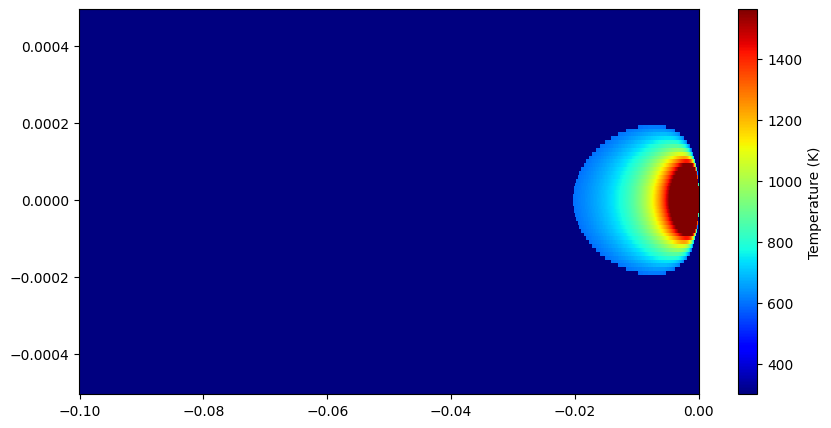

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
masked_temp_field = temp_field
masked_temp_field[masked_temp_field < 600] = 0
c = ax.pcolormesh(xs, ys, masked_temp_field[:, :, -1], cmap = 'jet', vmin = 300, vmax = 1563)
fig.colorbar(c, ax=ax, label="Temperature (K)")
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

 98%|█████████▊| 49/50 [00:17<00:00,  2.54it/s]

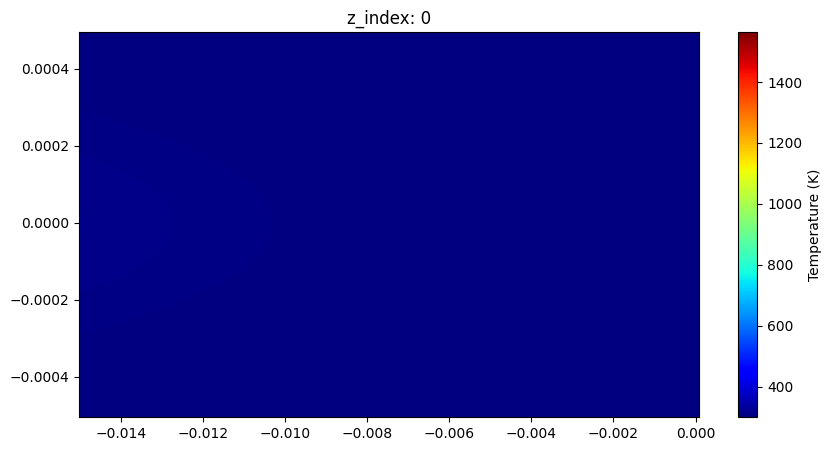

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
c = ax.pcolormesh(xs, ys, temp_field[:, :, 0], cmap = 'jet', vmin = 300, vmax = 1563)
fig.colorbar(c, ax=ax, label="Temperature (K)")

def update(z_index):
    ax.clear()
    ax.set_title(f"z_index: {z_index}")
    ax.pcolormesh(xs, ys, temp_field[:, :, z_index], cmap = 'jet', vmin = 300, vmax = 1563)

animate = FuncAnimation(fig, update, frames=(tqdm(range(len(zs)))))
animate.save(f"rosenthal_preview.gif", writer=PillowWriter(fps=20))

In [7]:
# Rosenthal External Reference Frame

# Inconel 625 alloy properties
epsilon = 0.60            # absorptivity
k = 10                    # thermal_conductivity
rho = 8400                # density
c_p = 470                 # heat_capacity
alpha = k / (rho * c_p)   # thermal_diffusivity
t_delta = 1299.85         # temperature melting - temperature initial
t_infinity = 300          # preheat
power = 638
velocity = 2

def rosenthal_temperature_field(x, y, z, temp_ceiling = None):
    """
    Assumes that (0, 0, 0) is the point heat source.
    """
    # Assuming x is along the weld center line
    zeta = -x

    # r is the cylindrical radius composed of y and z
    r = np.sqrt(y**2 + z**2)

    R = np.sqrt(zeta**2 + r**2)

    first_term = (power * epsilon) / (2 * np.pi * k * R)

    second_and_third_term = np.exp((velocity * (zeta - R))/ (2 * alpha))

    temp = t_infinity + first_term * second_and_third_term

    if temp_ceiling is not None:
        temp = np.minimum(temp, temp_ceiling)

    return temp

zs = np.arange(-5*10**-4, 0, 10**-5)
ys = np.arange(-5 * 10**-4, 5 * 10**-4, 10**-5)
xs = np.arange(-1.5 * 10**-2, 10**-4, 10**-5)

X, Y, Z = np.meshgrid(xs, ys, zs)

temp_field = rosenthal_temperature_field(X, Y, Z, temp_ceiling=1563)
print(temp_field.shape, np.min(temp_field), np.max(temp_field))

(100, 1510, 50) 300.0 1563.0
